#WW Points Minimization for Athlete Diet
**OPIM 5641:** Business Decision Modeling - University of Connecticut

**Group 1:** Lei Cao, Kurtis Mudre, Mrunmayi Shiveshwarkar, Karina Soto

# Athletic Diet
We are picking food items off of Wienerschnitzel's menu that must meet the  nutrition profile of the Athletic Diet. With our constraints we will get an optimal solution that won't be so appetizing. So we will introduce some more constraints that will give us a better selection of foods, but it will drive the Weight Watcher points up.

## Research - Athlete Diet per 160 lb Male
- Calories: 
  - 1,608 without fat
  - 2,000 with fat
    - Two values are shown because the data set given does not include fat.
- Protein: 87 g to 102 g (17.5% - 20.4%)
  - Endurance training athletes are recommended to comsume 1.2 - 1.4 grams of protein per kilogram of their bodyweight. Protein is used for the repairing and developing of muscle.
- Carbohydrates: 275 g to 300 g (55% - 60%) 
  - An athlete that is participating within normal levels of training is recommended to have 55% - 60% of their calories be carbohyrates. Carbohydrates are the main source of energy for activity.
- Sodium: Consumption >= 2,300 mg
  - Sodium intake is more generous for athletes due to sodium being vital for the sodium potassium pump which facilitates muscular function.
- Sugar: Consumption <= 50 g (consumption <= 10%) 
  - Sugar is a simple carbohydrate, which means that it is good for immediate energy, but can lead to energy crashes. Complex carbohydrates are a much better option for sustaining energy if possible.
  
Reputable sources: *Nutrition for Health, Fitness & Sport*, 10th Edition, By:
Melvin H Williams, Dawn Anderson, Eric Rawson

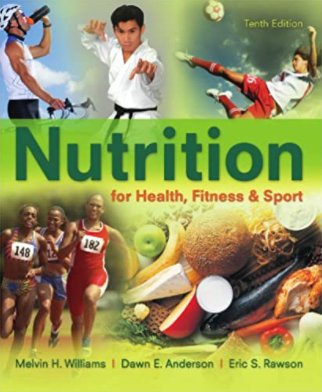

## Importing Pyomo

In [ ]:
# mount your drive
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("glpsol") or os.path.isfile("glpsol")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("glpsol") or os.path.isfile("glpsol"))

from pyomo.environ import *

SOLVER = 'glpk'
EXECUTABLE = '/usr/bin/glpsol'

     |████████████████████████████████| 9.4MB 534kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 256kB 38.7MB/s 
     |████████████████████████████████| 163kB 35.9MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-

## Importing Data

In [ ]:
# Read data from Excel file
from google.colab import files
# Command to upload file
uploaded = files.upload()

Saving Wienerschnitzel Nutrition Info.xlsx to Wienerschnitzel Nutrition Info.xlsx


In [ ]:
# Import modules
import pandas as pd
import io

# Transform excel file in a pandas dataframe
df = pd.read_excel('Wienerschnitzel Nutrition Info.xlsx')       # read the uploaded excel file
df = df.dropna().reset_index(drop=True)        # clean the data
print(df)       # check data

                                        Food  Calories  ...  Sugars  Weight Watchers
0    Original Chili Cheese Dog, standard bun       320  ...       4                9
1           Original Chili Dog, standard bun       270  ...       4                8
2         Original Mustard Dog, standard bun       240  ...       4                7
3          Original Relish Dog, standard bun       250  ...       6                7
4           Original Kraut Dog, standard bun       240  ...       5                7
..                                       ...       ...  ...     ...              ...
175                      Mug Root Beer Float       440  ...      73               13
176              Mini Sundae, Hot Fudge 3 oz       200  ...      26                6
177              Mini Sundae, Chocolate 3 oz       180  ...      28                5
178             Mini Sundae, Strawberry 3 oz       170  ...      25                5
179                Mini Sundae, Caramel 3 oz       200  ...      

In [ ]:
# Set a new column for segmentation
df['Segment'] = np.nan    # create a column to identify the type of food item
df.loc[0:45, ['Segment']] = 'Hot Dog'       # Original and Angus Hot dogs 
df.loc[46:85, ['Segment']] = 'Burger'       # Burger & Specialty menu
df.loc[86:109, ['Segment']] = 'Breakfast'   # Breakfast menu  
df.loc[110:157, ['Segment']] = 'Drinks'     # Drinks menu
df.loc[158:, ['Segment']] = 'Desserts'      # Tastee Freez Dessert menu
print(df)

                                        Food  ...   Segment
0    Original Chili Cheese Dog, standard bun  ...   Hot Dog
1           Original Chili Dog, standard bun  ...   Hot Dog
2         Original Mustard Dog, standard bun  ...   Hot Dog
3          Original Relish Dog, standard bun  ...   Hot Dog
4           Original Kraut Dog, standard bun  ...   Hot Dog
..                                       ...  ...       ...
175                      Mug Root Beer Float  ...  Desserts
176              Mini Sundae, Hot Fudge 3 oz  ...  Desserts
177              Mini Sundae, Chocolate 3 oz  ...  Desserts
178             Mini Sundae, Strawberry 3 oz  ...  Desserts
179                Mini Sundae, Caramel 3 oz  ...  Desserts

[180 rows x 8 columns]


# Model 2

For this model, we will be adding more constraints to have a more diverse mix of items to eat from the menu while still minimizing the Weight Watcher points.

Having just one drink a day does not sound like a very healthy or logical diet for an athlete. To get a more healthy answer for the food items, we can change/add a few constraints and check how the model works.

* We can add a lower bound and an upper bound for all the food item variables, to ensure we have a diverse mix of items in the menu.
* We can increase the upper bound a little for the sugar constraint, to get another drink in the diet, as most of the drinks are high on sugar.
As we need to stick to the value $50g$ specified in the athlete diet, we can add a lower bound of $30g$ and an upper bound of $70g$, which still maintains an average intake of about $50g$ for sugar content.
* Additionally, looking at the fact that Carbs content is a binding constraint, we can tweak the constraint a little to try and get minimum Weight Watcher value in the second model.

## Parameters & Constraints

* We added a lower bound of 0 and a higher bound of 1 to ensure that no single food item is included twice in the diet.

* We tried tweaking the lower bounds Carbs content. When we ran the model with no lower bound for Carbs, the value of this constraint came close to ~$160$. However, reducing the lower bounds to this value would no longer be in accordance with the Athlete Diet, that we plan to stick to. So we tried multiple values of Carb constraint, and decided on going with $225$, as for this value, we got a good balance of food items for the diet.



**OBJECTIVE FUNCTION**

$ WW = \sum (Food Item Quantity * Food Item's WW points) $

-----------------------

**CONSTRAINTS**

$Min(Z) = \sum (Food Item Quantity * Food Item's WW points) $

Subject to:
* $ \sum (Food Item Calories*Food Item's Quantity) >= 1608$ `calories`
* $ \sum (Food Item Protein*Food Item's Quantity)	>= 87$ `protein minimum requirement`
* $ \sum (Food Item Protein*Food Item's Quantity)	<= 102 $ `protein maximum requirement`
* $ \sum (Food Item Carbs*Food Item's Quantity)	>= 225 $ `lowered carbs minimum requirement`
* $ \sum (Food Item Carbs*Food Item's Quantity) <= 300$ `carbs maximum requirement`
* $ \sum (Food Item Sodium*Food Item's Quantity)	>= 2300$ `sodium`
* $ \sum (Food Item Sugar*Food Item's Quantity)	>= 30$ `additional lower bound for sugars`
* $ \sum (Food Item Sugar*Food Item's Quantity)	<= 70$ `additional upper bound for sugars`
* $ Food Item Quantity >= 0$ `non-negativity`

**Additional Constraints:**

We will be adding a lower bound for each food item as 0, and an upper bound of 1 to make sure no food item is included in excess.
* $Food Item Quantity >= 0$
* $ Food Item Quantity <= 1$


In [ ]:
# List of product indices
products = df.index.values.tolist()
print("products", products)

# Extract list of foods, use transpose operation, and create dictionary index->food name
product_name = df["Food"].T.to_dict()
print(product_name)

# The command below gives us the list of column names
print(list(df))

# List of nutrients - Remove first element, as it is not a nutrient
nutrients = list(df)[1:]
print("nutrients", nutrients)

# Extract columns with values, transform column in list
weight_watchers = df["Weight Watchers"].tolist()
print("Weight Watchers", weight_watchers)

# Extract nutritional values
nut_value = dict()
for nutrient in nutrients:
  nut_value[nutrient] = df[nutrient].tolist()    # get list of values of nutrients for each segment
print(nut_value)


products [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
{0: 'Original Chili Cheese Dog, standard bun', 1: 'Original Chili Dog, standard bun', 2: 'Original Mustard Dog, standard bun', 3: 'Original Relish Dog, standard bun', 4: 'Original Kraut Dog, standard 

In [ ]:
# declare the model
model = ConcreteModel()

# declare decision variables
model.volume = Var(products, domain=NonNegativeIntegers, bounds=(0,1))

# declare objective function
obj_expr = 0      # initialize objective function
for product in products:
  obj_expr += weight_watchers[product]*model.volume[product]      # iteratively add expressions in objective function for each food segment
# add objective funtion to the model
model.ww = Objective(
                      expr = obj_expr,      # specify the objective function
                      sense = minimize)     # specify that the objective function needs to be minimized

# declare constraint list
model.constraints = ConstraintList()

# for nutrient in nutrients, initialize the constraints
ca_exp = 0
pr_exp = 0
cb_exp = 0
so_exp = 0
su_exp = 0
ww_exp = 0

# iterate through the products, get expressions multiplying the products with the nutrient values
for product in products:
  ca_exp += nut_value['Calories'][product]*model.volume[product]
  pr_exp += nut_value['Protein'][product]*model.volume[product]
  cb_exp += nut_value['Carb'][product]*model.volume[product]
  so_exp += nut_value['Sodium'][product]*model.volume[product]
  su_exp += nut_value['Sugars'][product]*model.volume[product]
  ww_exp += nut_value['Weight Watchers'][product]*model.volume[product]

# add the constraints generated to the model
model.constraints.add(expr = ca_exp >= 1608)
model.constraints.add(expr = pr_exp >= 87)
model.constraints.add(expr = pr_exp <= 102)
model.constraints.add(expr = cb_exp >= 225)     # reduced lower bound for carbs content
model.constraints.add(expr = cb_exp <= 300)
model.constraints.add(expr = so_exp >= 2300)
model.constraints.add(expr = su_exp >= 30)      # newly added lower bound for sugar content
model.constraints.add(expr = su_exp <= 70)      # newly added upper bound for sugar content

# show the model you've created
model.pprint()

2 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {1, 2, 3, 4, 5, 6, 7, 8}
    volume_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  180 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,

## Solve model

In [ ]:
# solve the model
SolverFactory(SOLVER, executable=EXECUTABLE).solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 48.0
  Upper bound: 48.0
  Number of objectives: 1
  Number of constraints: 9
  Number of variables: 179
  Number of nonzeros: 1299
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 317
      Number of created subproblems: 317
  Error rc: 0
  Time: 0.08349275588989258
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

## Results

In [ ]:
# show the results for weight watchers calculated
print("Weight Watcher = ", model.ww())
# show the values for food items calculated
results = {}        # empty dict to store result
for product in products:
  # print(product_name[product],model.volume[product]())
  results.update({product_name[product]: model.volume[product]()})      # update result dict

theResults = pd.DataFrame.from_dict(results, orient='index').rename(columns={0: 'Quantity'})    # save the results as a dataframe and rename the column

theResults[theResults["Quantity"]>0]    # print result

Weight Watcher =  48.0


,Quantity
"Original Mustard Dog, pretzel bun",1.0
"Original Plain Dog, pretzel bun",1.0
Hamburger,1.0
BBQ Sauce,1.0
Chili Cheese Burrito,1.0
1% Low Fat Milk,1.0
"Chocolate Milk, Low Fat (1%)",1.0


The second model here presents a more variety of food items in the suggested diet, with an addition of chocolate milk. This menu definitely looks more appealing, as it suggests an intake of $2$ hotdogs, $1$ burger, some barbeque sauce, a burrito and $2$ glasses of milk.

And to add to these improvisations, the weight watcher score also reduced from $56$ to $48$, which is a great improvement over model 1.

## Binding Constraints


In [ ]:
# display model constraints and their values
model.constraints.display()

constraints : Size=8
    Key : Lower  : Body   : Upper
      1 : 1608.0 : 1840.0 :  None
      2 :   87.0 :   87.0 :  None
      3 :   None :   87.0 : 102.0
      4 :  225.0 :  229.0 :  None
      5 :   None :  229.0 : 300.0
      6 : 2300.0 : 4640.0 :  None
      7 :   30.0 :   70.0 :  None
      8 :   None :   70.0 :  70.0


**LHS and RHS values of the constraints:**

* The values in the column `Body` indicate the **LHS** of the constraint, that is the value calculated for the expression on the LHS of the constraint.

* The values shown in the columns `Lower` and `Upper` indicate the **RHS** values of the constraint. These are the values that we specified while defining the constraints.

Although the Carbs constraint is no longer binding, the Protein and Sugar constraints are now binding, after adding the upper bound for each food item, and an upper and lower bound for sugar content.

# Conclusion

* In conclusion, to come up with an acceptable, logical and a palatable menu for a 160 lb male athlete, we had to compromise a little on the nutrient requirements specified by the Athlete Diet. 
* We were able to achieve additional variety in the diet, with the diet consisting of proper solid food as well as healthy mix of drinks suitable for an athlete.
* The weight watcher score obtained for our first model was $56$, but surprisingly, after some changes in the constraints in our second model, the weight watcher score decreased to $48$, while accomodating a variety of food items in the diet.
* In the second model, we were able to tackle the binding constraint on carbs content. However, in doing so, the constraints on protein and sugar content turned to being binding.
* Lastly, referring to the table below, looking at the average contents of nutrients in each of the food item types, and the weight watcher score it contributes, the Wienerschnitzel restaurant could benefit from serving high protein drinks, high sodium desserts and high sugar burgers or breakfast items for athletes.

In [ ]:
# create dataframe with average nutrient contents for each type of food item
print('\033[1m',"AVERAGE NUTRIENT CONTENT AND WEIGHT WATCHER SCORE FOR EACH FOOD TYPE:",'\033[1m')
avg = pd.DataFrame(df.groupby('Segment', sort=False).mean())
avg = avg.reset_index()
avg

 AVERAGE NUTRIENT CONTENT AND WEIGHT WATCHER SCORE FOR EACH FOOD TYPE: 


,Segment,Calories,Protein,Carb,Sodium,Sugars,Weight Watchers
0,Hot Dog,438.260870,16.065217,45.369565,1299.782609,7.673913,12.130435
1,Burger,430.125000,20.125000,32.000000,1211.000000,4.025000,11.900000
2,Breakfast,408.333333,13.666667,35.916667,1006.458333,5.250000,11.208333
3,Drinks,247.187500,0.937500,64.500000,136.041667,64.125000,7.229167
4,Desserts,461.818182,8.363636,73.227273,288.409091,58.545455,13.454545
